In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import time
import pandas as pd
import numpy as np
import webrtcvad as wb
import matplotlib.pyplot as plt
import kagglehub as kh
import audiofile
from pydub import AudioSegment
import librosa

/home/pankrat/project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pankrat/project/venv/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
train_data_paths = ['/home/pankrat/project/training/' + file for file in os.listdir('/home/pankrat/project/training') if ".wav" in file]
val_data_paths = ['/home/pankrat/project/validation/' + file for file in os.listdir('/home/pankrat/project/validation') if ".wav" in file]
test_data_paths = ['/home/pankrat/project/testing/' + file for file in os.listdir('/home/pankrat/project/testing') if ".wav" in file]

In [3]:
print(len(train_data_paths))
print(train_data_paths[0])

3456
/home/pankrat/project/training/03-01-06-02-01-01-15.wav


In [4]:
np.version.version

'2.0.0'

In [5]:
from scipy.signal import stft, istft
from scipy.signal.windows import hamming
from scipy.io import wavfile
import pywt
from skimage.exposure import match_histograms

In [33]:
def extract_features(data):
    # ZCR
    sample_rate = 16000
    # result = np.array([])
    zcr = librosa.feature.zero_crossing_rate(y=data)
    # result=np.vstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
    # result = np.vstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    # result = np.vstack((result, mfcc)) # stacking horizontally
    # print(mfcc.shape)

    # Root Mean Square Value
    rms = librosa.feature.rms(y=data)
    # result = np.vstack((result, rms)) # stacking horizontally
    
    # MelSpectogram
    mel = librosa.feature.melspectrogram(y=data, sr=sample_rate)
    # result = np.vstack((result, mel))
    
    return torch.tensor(np.vstack((zcr, chroma_stft, mfcc, rms, mel)), dtype=torch.float32)

In [80]:
def preprocess_audio(audio_paths, augment_data=False, show_spectrogram=False, output_filtered_audio=False):
    resample_rate = 16000
    window_size = int(resample_rate * 0.04)
    window = window = hamming(window_size)
    data = []

    for i, aud_path in enumerate(audio_paths):
        audio_clip = aud_path.split('/')[-1]
        label = int(audio_clip[7]) - 1
        if i % 100 == 0:
            print(i)

        aud, sr = librosa.load(aud_path)

        features = extract_features(aud)
        data.append((features, label))

    return data
    
train_data = preprocess_audio(train_data_paths)
val_data = preprocess_audio(val_data_paths)
test_data = preprocess_audio(test_data_paths)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
0
100
200
0
100
200
300


In [114]:
torch.save(train_data_new, '/home/pankrat/project/training/train.data')
torch.save(val_data_new, '/home/pankrat/project/validation/val.data')
torch.save(test_data_new, '/home/pankrat/project/testing/test.data')

In [83]:
input_size=train_data[0][0].shape[0]
print(train_data[0][0].shape)

torch.Size([162, 81])


In [115]:
train_data2 = torch.load('/home/pankrat/project/training/train.data')
val_data2 = torch.load('/home/pankrat/project/validation/val.data')
test_data2 = torch.load('/home/pankrat/project/testing/test.data')

/tmp/ipykernel_49323/2848290331.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data2 = torch.load('/home/pankrat/project/training/train.data')
/tmp/ipykernel_4932

In [125]:
class SER_Dropout_Model(nn.Module):
    def __init__(self, input_size=input_size, pool_size=5, kernel_size1=3, kernel_size2=5, hidden_size=80, hidden_size2=10, cout=60, cout2=40, p=0.5, num_classes=8):
        # self.fcnn_size = fcnn_size
        # self.scnn_size = scnn_size

        # CNN to grab deep features from the spectrogram image
        super().__init__()

        pool_stride = 1
        pool_padding = 0
        stride = 2
        padding = 0

        self.MFCC_feature_extraction = nn.Sequential(
          nn.Conv1d(input_size, cout, kernel_size=kernel_size1, stride=stride, padding=padding),
          nn.MaxPool1d(kernel_size=pool_size, stride=pool_stride, padding=pool_padding),
          nn.Dropout(p),
          nn.Conv1d(cout, cout2, kernel_size=kernel_size2, stride=stride, padding=padding),
          nn.MaxPool1d(kernel_size=pool_size, stride=pool_stride, padding=pool_padding),
        )

        input_size3 = 4 * hidden_size

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(cout2, hidden_size, bidirectional=True, batch_first=True)

        self.classify = nn.Sequential(
          nn.BatchNorm1d(input_size3),
          nn.Linear(input_size3, hidden_size2),
          nn.Dropout(p),
          nn.ReLU(),
          nn.Linear(hidden_size2, 50),
          nn.Dropout(p),
          nn.ReLU(),
          nn.Linear(50, num_classes),
        )

    def forward(self, X):
        # Get deep features
        deep_features = self.MFCC_feature_extraction(X).squeeze(dim=1) # Get deep features
        out, (h_n, c_n) = self.lstm(deep_features.permute(0, 2, 1)) # Use h_n for deep features

        features = torch.cat([torch.amax(out, dim=1),
                              torch.mean(out, dim=1)], axis=-1)
        out = self.classify(features)
        return out

In [106]:
def collate_batch(batch):
    """
    Returns the input and target tensors for a batch of data

    Parameters:
        `batch` - An iterable data structure of tuples (indices, label),
                  where `indices` is a sequence of word indices, and
                  `label` is either 1 or 0.

    Returns: a tuple `(X, t)`, where
        - `X` is a PyTorch tensor of shape (batch_size, sequence_length)
        - `t` is a PyTorch tensor of shape (batch_size)
    where `sequence_length` is the length of the longest sequence in the batch
    """

    features_list = []  # collect each sample's spectrogram
    label_list = [] # collect each sample's target labels
    for (features, label) in batch:
        features_list.append(features.squeeze(0).T)
        # print(spec.shape)
        label_list.append(label)
    # Use permute
    X = pad_sequence(features_list, batch_first=True, padding_value=0).permute(0, 2, 1)
    t = torch.tensor(label_list)
    return X, t

In [156]:
def accuracy(model, dataset, max=1000):
    """
    Estimate the accuracy of `model` over the `dataset`.
    We will take the **most probable class**
    as the class predicted by the model.

    Parameters:
        `model`   - An object of class nn.Module
        `dataset` - A dataset of the same type as `train_data`.
        `max`     - The max number of samples to use to estimate
                    model accuracy

    Returns: a floating-point value between 0 and 1.
    """

    correct, total = 0, 0
    dataloader = DataLoader(dataset,
                            batch_size=100,  # use batch size 1 to prevent padding
                            collate_fn=collate_batch)
    for i, (x, t) in enumerate(dataloader):
        z = model(x)
        y = torch.argmax(z, axis=1)
        correct += int(torch.sum(t == y))
        total += 1
    return correct / total

In [98]:
def init_layer_weights(model):
    """
    Initialize the layer weights of `model` with Xavier initialization.
    """
    if isinstance(model, nn.Linear):
        nn.init.xavier_uniform_(model.weight)  # Xavier Uniform Initialization
        nn.init.zeros_(model.bias)  # Initialize bias to zero
    elif isinstance(model, nn.Conv2d):
        nn.init.xavier_uniform_(model.weight)  # Xavier initialization for Conv layers
        nn.init.zeros_(model.bias)
    elif isinstance(model, nn.LSTM):
        nn.init.xavier_uniform_(model.weight_ih_l0)
        nn.init.xavier_uniform_(model.weight_hh_l0)


In [108]:
def train_model(model,
                train_data,
                val_data,
                learning_rate=0.001,
                batch_size=100,
                num_epochs=10,
                plot_every=100,
                plot=True,
                collate_fn=collate_batch):
    # Use cross entropy loss for classification
    criterion=nn.CrossEntropyLoss()
    # Use Adam optimizer.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    iters = []
    train_losses = []
    train_accs = []
    val_accs = []
    iter_count = 0
    prev_batch = None

    try:
        for e in range(num_epochs):
            train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                          collate_fn=collate_batch)
            for i, (x, labels) in enumerate(train_dataloader):
                z = model(x)
                loss = criterion(z, labels)

                loss.backward() # propagate the gradients
                # if iter_count % plot_every == 0:
                #     print_gradient_norms(model)

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step() # update the parameters
                optimizer.zero_grad() # clean up accumualted gradients

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    ta = accuracy(model, train_data)
                    va = accuracy(model, val_data)
                    train_losses.append(float(loss))
                    train_accs.append(ta)
                    val_accs.append(va)
                    print("Epoch:", e, "iteration:", iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)
    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_losses)], train_losses)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_accs)], train_accs)
            plt.plot(iters[:len(val_accs)], val_accs)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend(["Train", "Validation"])

In [109]:
torch.cuda.is_available()

True

In [126]:
model = SER_Dropout_Model()
# model.load_state_dict(torch.load('/home/pankrat/project/model.pt', weights_only=True))
# model.eval()

Epoch: 1 iteration: 15 Loss: 2.045670509338379 Train Acc: 17.285714285714285 Val Acc: 10.666666666666666
Epoch: 2 iteration: 30 Loss: 2.013465404510498 Train Acc: 17.65714285714286 Val Acc: 13.666666666666666
Epoch: 3 iteration: 45 Loss: 2.0156028270721436 Train Acc: 18.942857142857143 Val Acc: 14.0
Epoch: 4 iteration: 60 Loss: 1.9400354623794556 Train Acc: 21.34285714285714 Val Acc: 12.666666666666666
Epoch: 5 iteration: 75 Loss: 1.9340424537658691 Train Acc: 21.771428571428572 Val Acc: 14.666666666666666
Epoch: 6 iteration: 90 Loss: 1.877373218536377 Train Acc: 23.942857142857143 Val Acc: 15.666666666666666
Epoch: 7 iteration: 105 Loss: 1.8607072830200195 Train Acc: 25.085714285714285 Val Acc: 16.0
Epoch: 8 iteration: 120 Loss: 1.7846460342407227 Train Acc: 26.6 Val Acc: 21.666666666666668
Epoch: 9 iteration: 135 Loss: 1.8426247835159302 Train Acc: 27.114285714285714 Val Acc: 15.666666666666666
Epoch: 10 iteration: 150 Loss: 1.7357261180877686 Train Acc: 27.542857142857144 Val Acc: 1

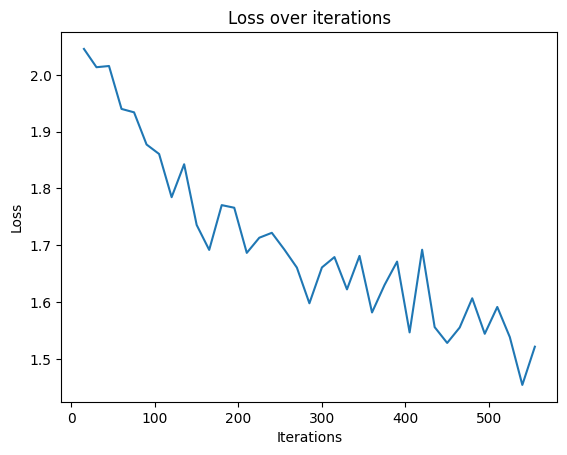

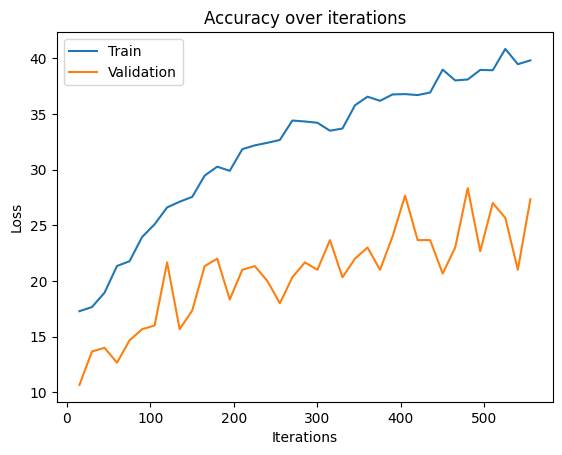

In [127]:
train_model(model, train_data2, val_data2, plot_every=15, batch_size=256, num_epochs=40)

In [128]:
kernel_sizes1 = [2, 3, 5]
kernel_sizes2 = [3, 5]
pool_sizes=[2, 4, 5]
ps = [0.3, 0.5]

Epoch: 2 iteration: 30 Loss: 1.8475302457809448 Train Acc: 26.085714285714285 Val Acc: 15.666666666666666
Epoch: 4 iteration: 60 Loss: 1.7589161396026611 Train Acc: 30.514285714285716 Val Acc: 19.333333333333332
Epoch: 6 iteration: 90 Loss: 1.6847646236419678 Train Acc: 34.74285714285714 Val Acc: 24.666666666666668
Epoch: 8 iteration: 120 Loss: 1.5631754398345947 Train Acc: 38.114285714285714 Val Acc: 26.333333333333332
Epoch: 10 iteration: 150 Loss: 1.578272819519043 Train Acc: 42.05714285714286 Val Acc: 28.333333333333332
Epoch: 12 iteration: 180 Loss: 1.4125007390975952 Train Acc: 44.51428571428571 Val Acc: 30.666666666666668
Epoch: 14 iteration: 210 Loss: 1.3855643272399902 Train Acc: 46.77142857142857 Val Acc: 29.666666666666668
Epoch: 17 iteration: 240 Loss: 1.3902515172958374 Train Acc: 47.48571428571429 Val Acc: 33.0
Epoch: 19 iteration: 270 Loss: 1.2081676721572876 Train Acc: 49.02857142857143 Val Acc: 34.0
Epoch: 21 iteration: 300 Loss: 1.1764519214630127 Train Acc: 51.542857

/tmp/ipykernel_49323/329214632.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()



Epoch: 2 iteration: 30 Loss: 2.063753604888916 Train Acc: 15.6 Val Acc: 7.666666666666667
Epoch: 4 iteration: 60 Loss: 1.9310604333877563 Train Acc: 21.914285714285715 Val Acc: 14.333333333333334
Epoch: 6 iteration: 90 Loss: 1.9530786275863647 Train Acc: 24.0 Val Acc: 15.666666666666666
Epoch: 8 iteration: 120 Loss: 1.8920239210128784 Train Acc: 27.65714285714286 Val Acc: 18.333333333333332
Epoch: 10 iteration: 150 Loss: 1.6894561052322388 Train Acc: 30.742857142857144 Val Acc: 21.0
Epoch: 12 iteration: 180 Loss: 1.7866122722625732 Train Acc: 30.37142857142857 Val Acc: 20.0
Epoch: 14 iteration: 210 Loss: 1.586557388305664 Train Acc: 32.885714285714286 Val Acc: 19.666666666666668
Epoch: 17 iteration: 240 Loss: 1.5670746564865112 Train Acc: 34.6 Val Acc: 20.333333333333332
Epoch: 19 iteration: 270 Loss: 1.694995403289795 Train Acc: 34.142857142857146 Val Acc: 22.333333333333332
Epoch: 21 iteration: 300 Loss: 1.6262822151184082 Train Acc: 36.42857142857143 Val Acc: 26.666666666666668
Epo

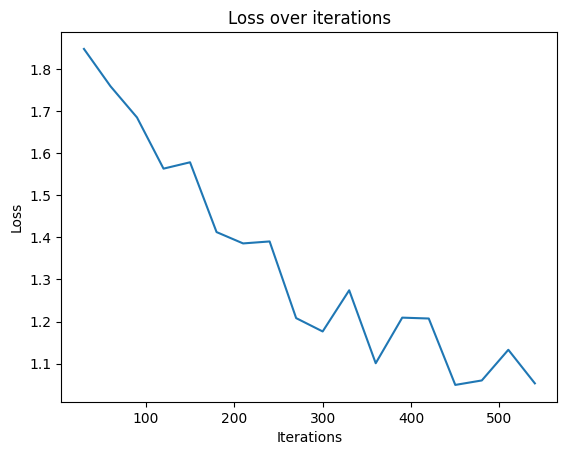

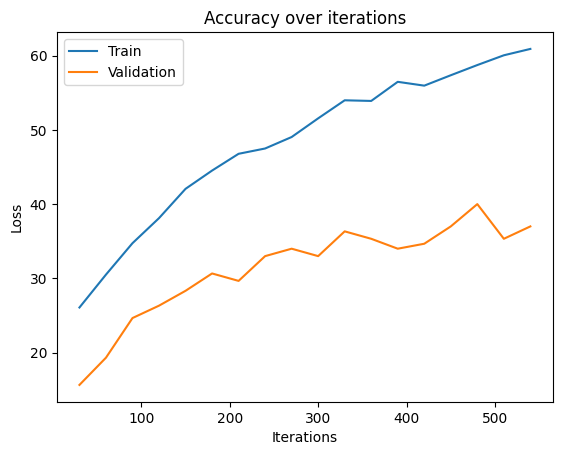

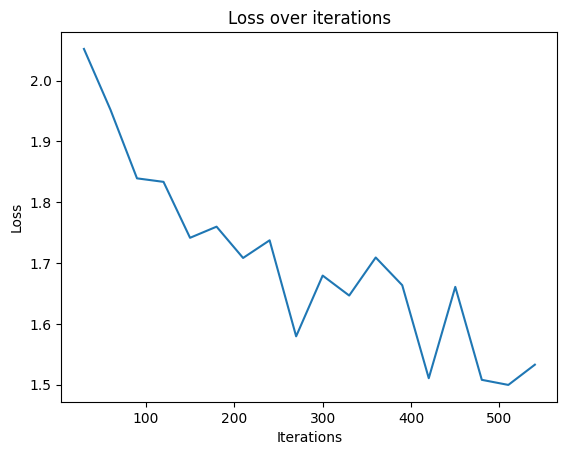

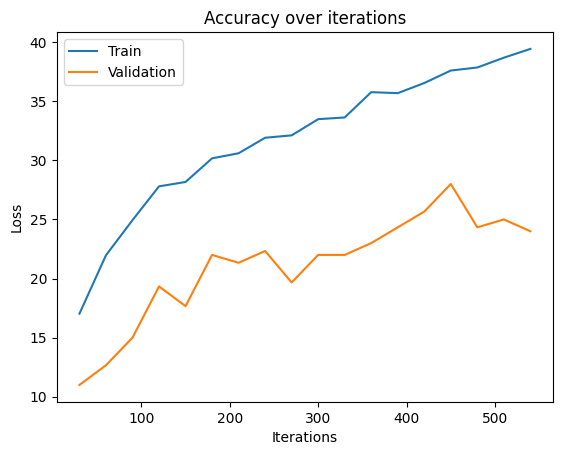

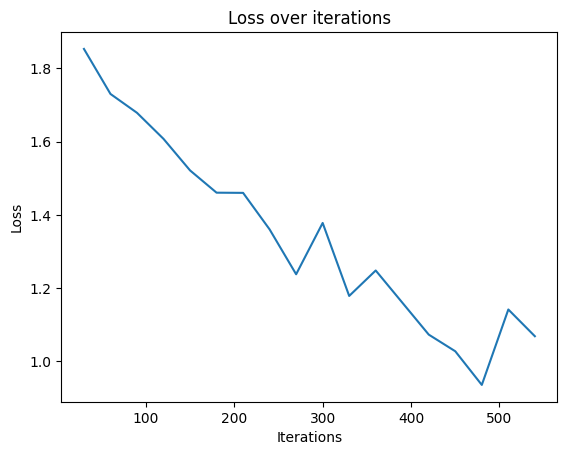

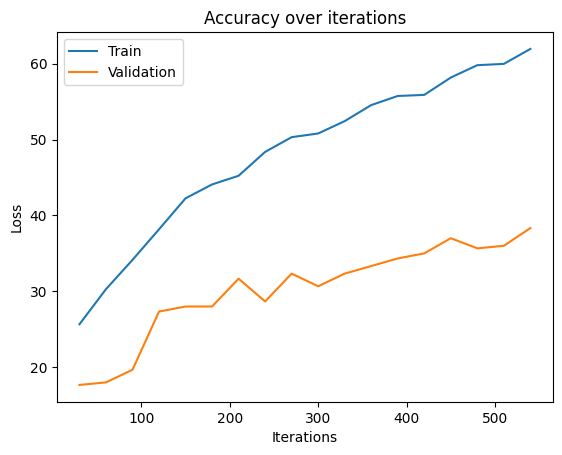

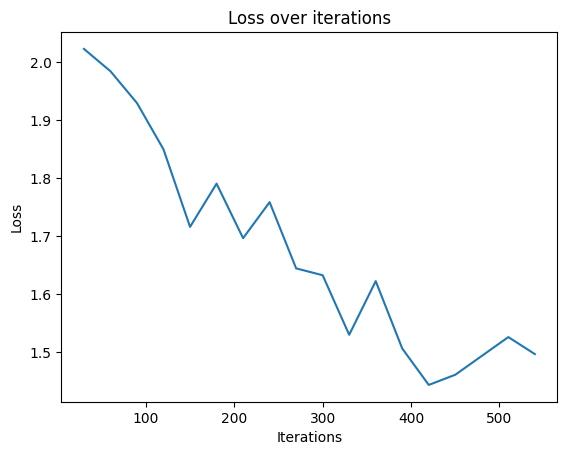

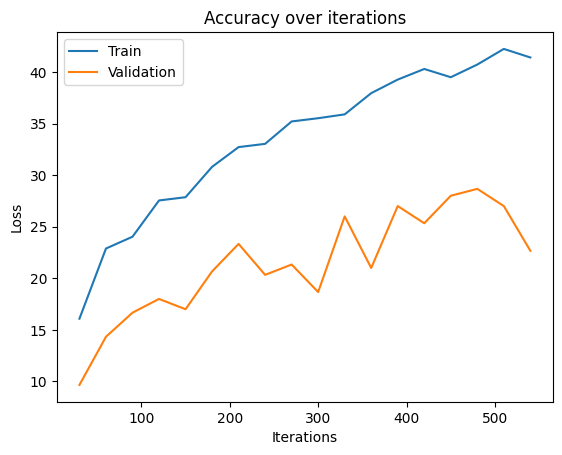

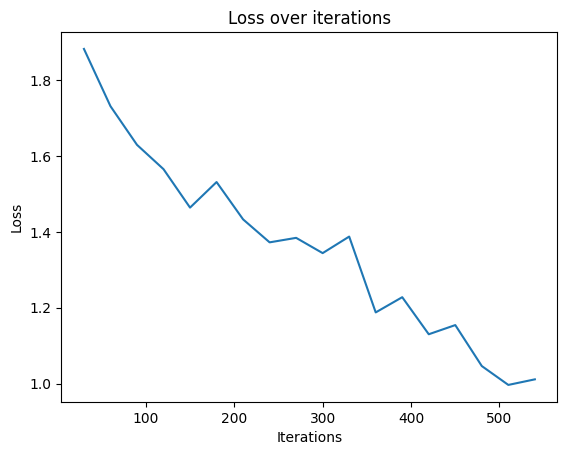

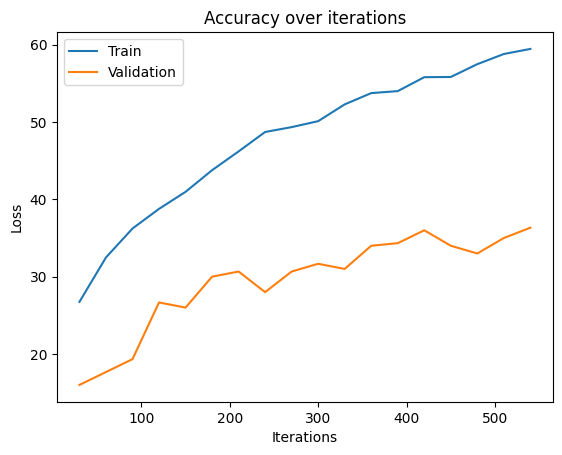

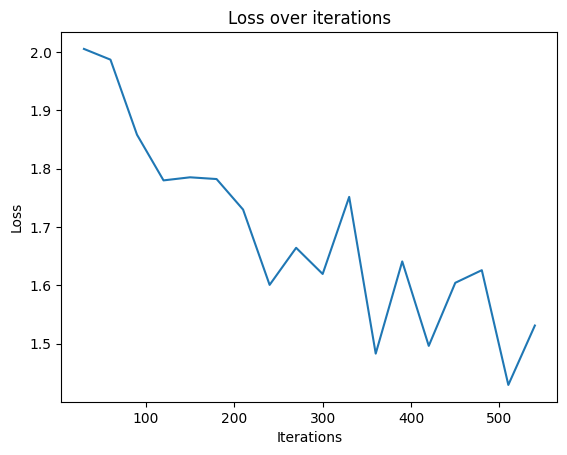

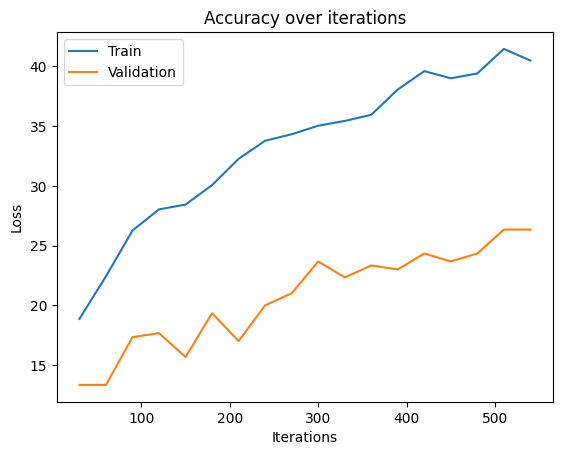

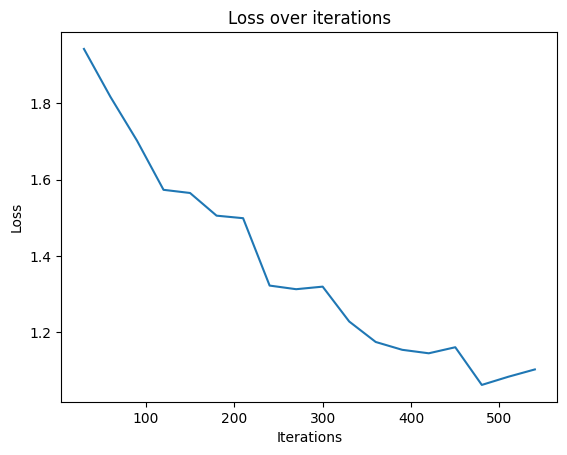

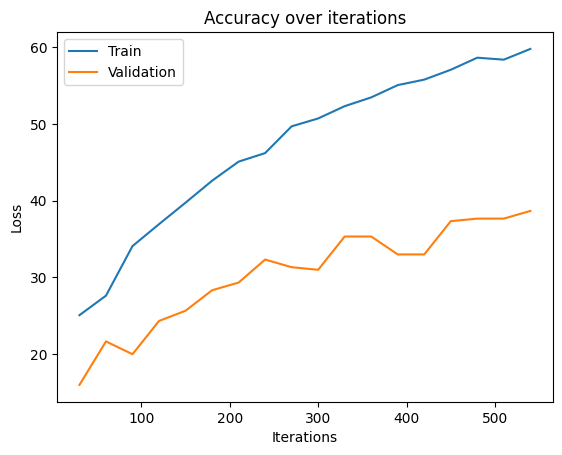

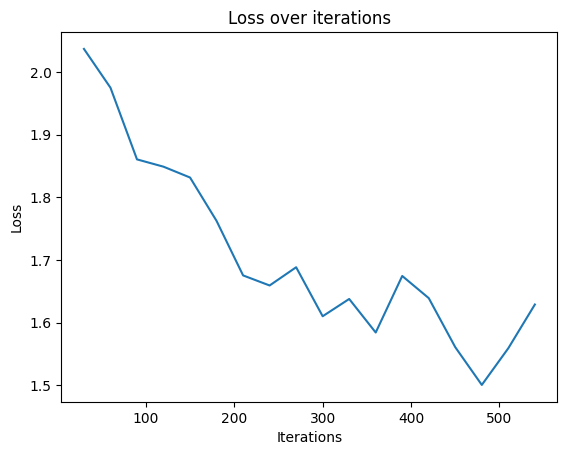

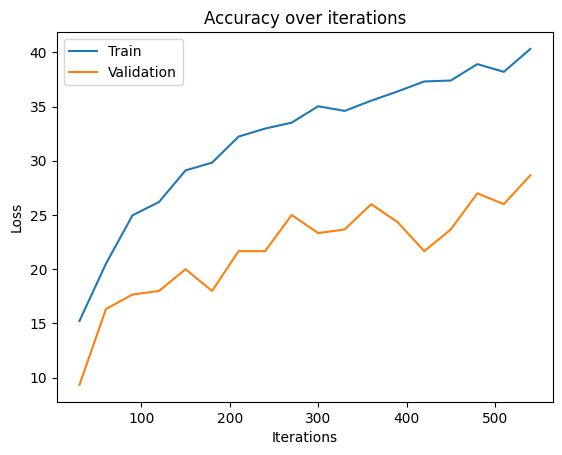

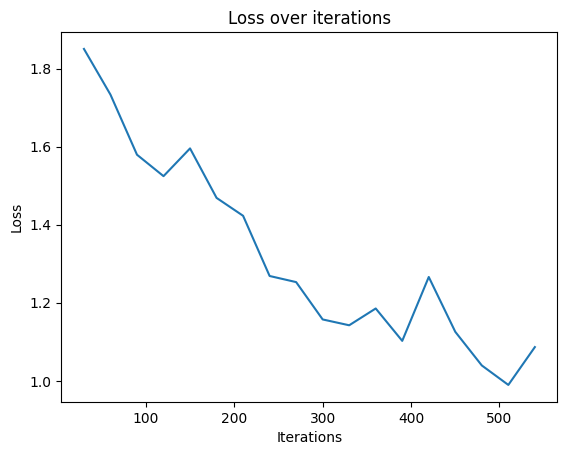

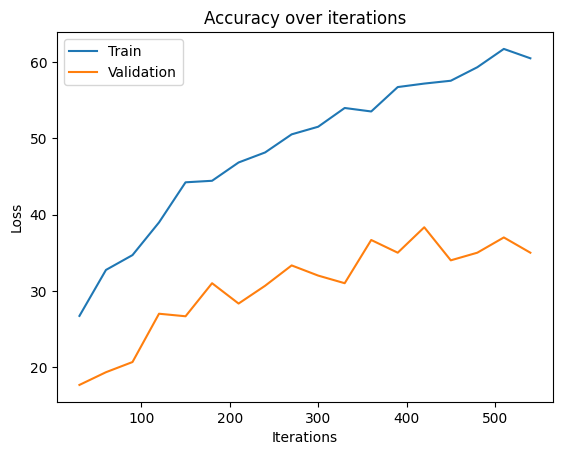

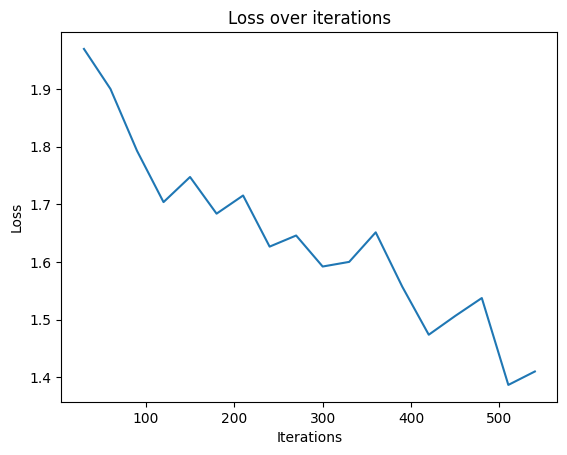

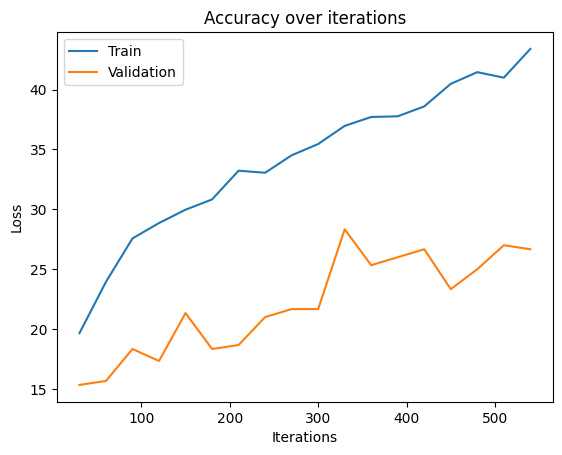

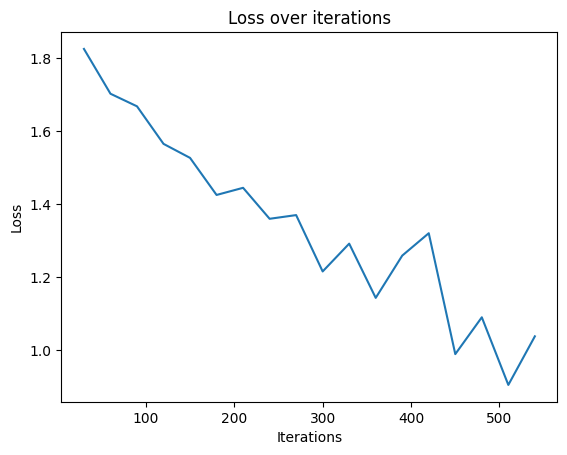

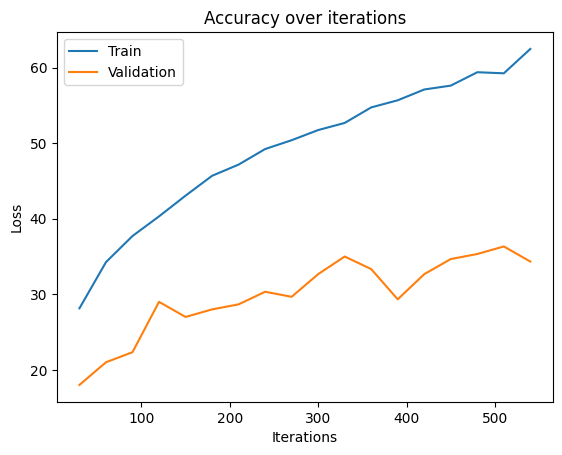

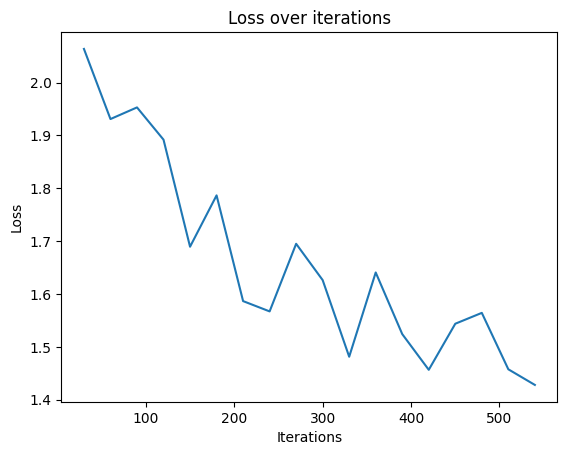

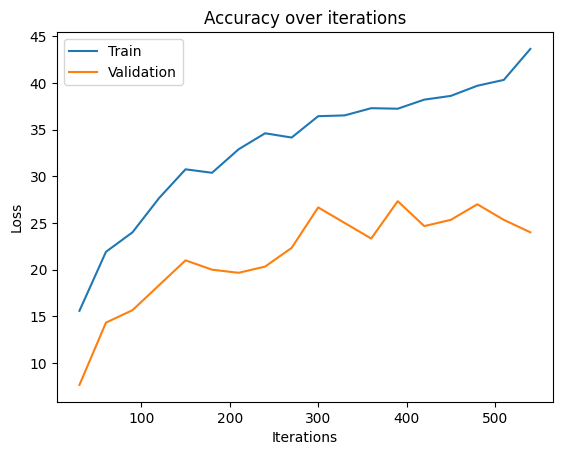

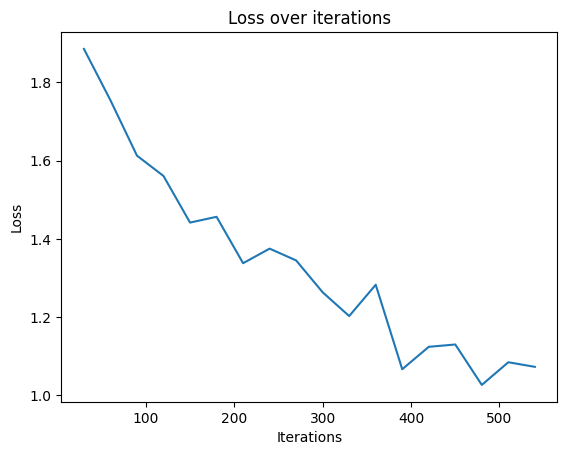

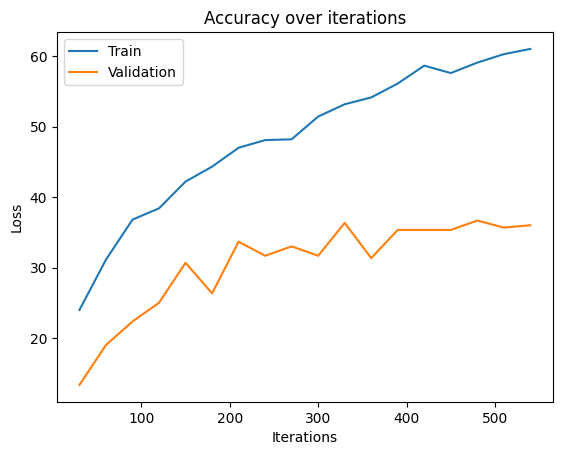

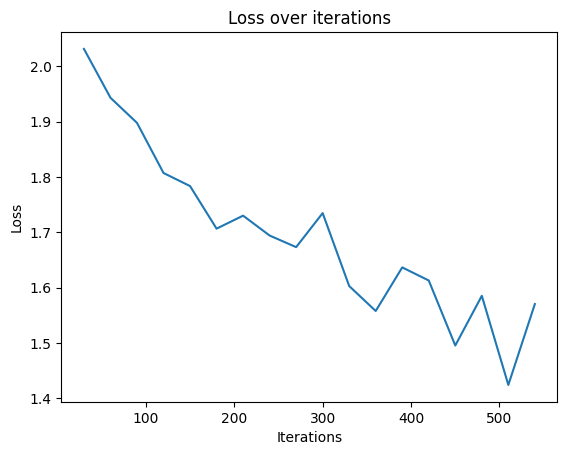

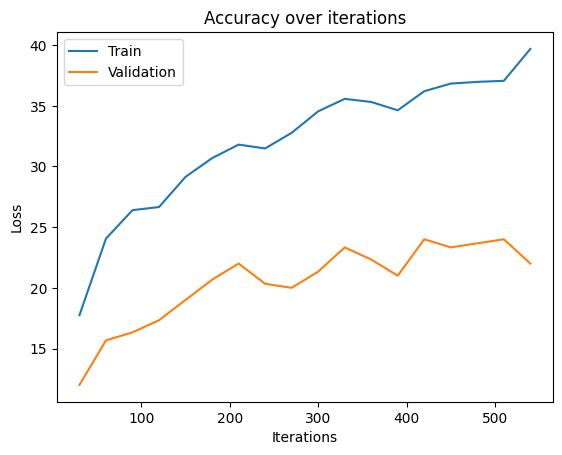

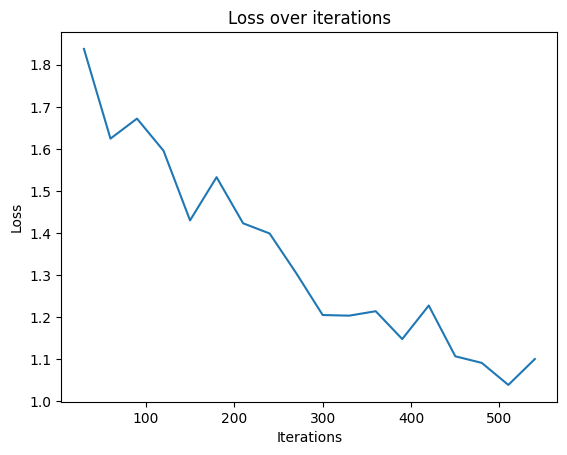

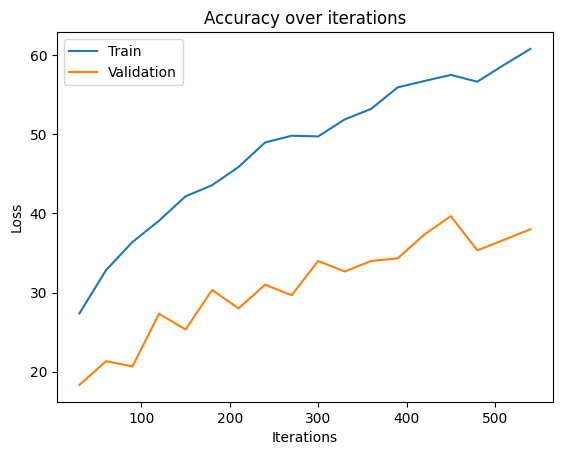

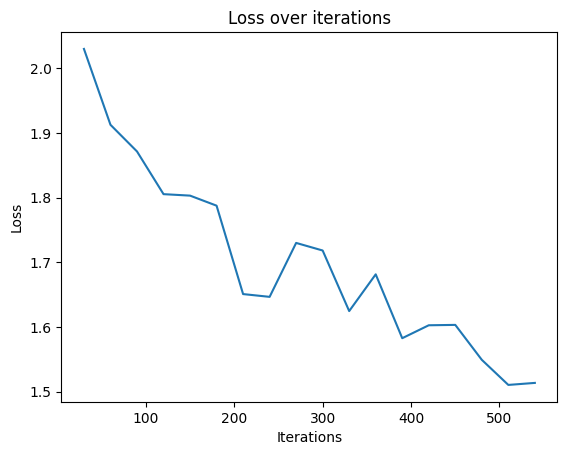

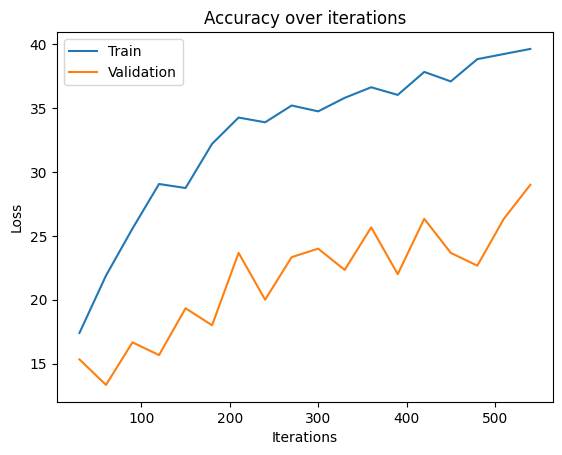

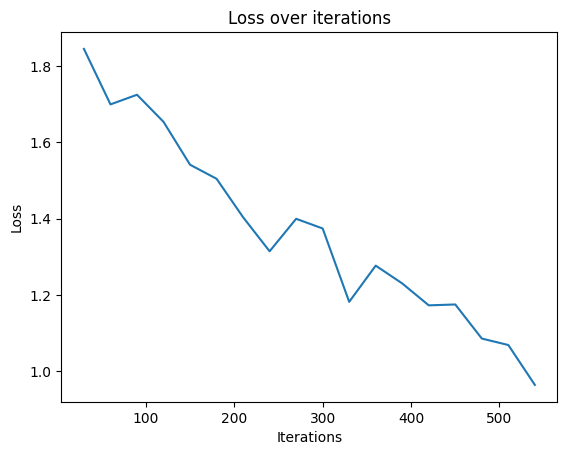

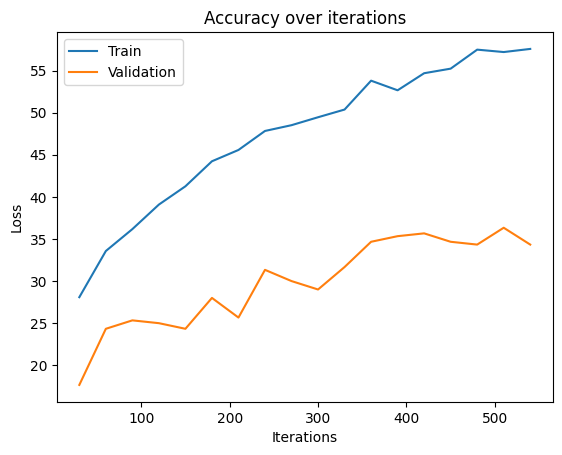

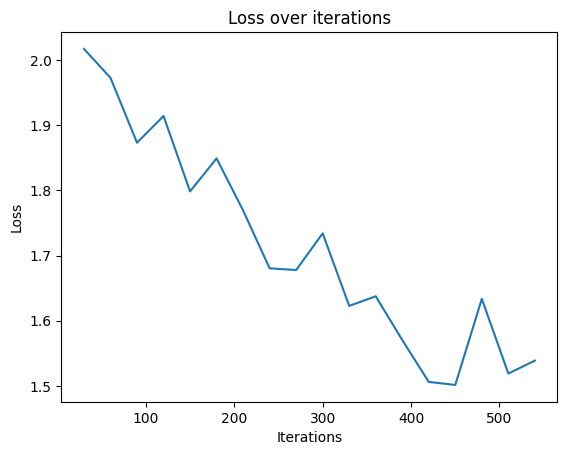

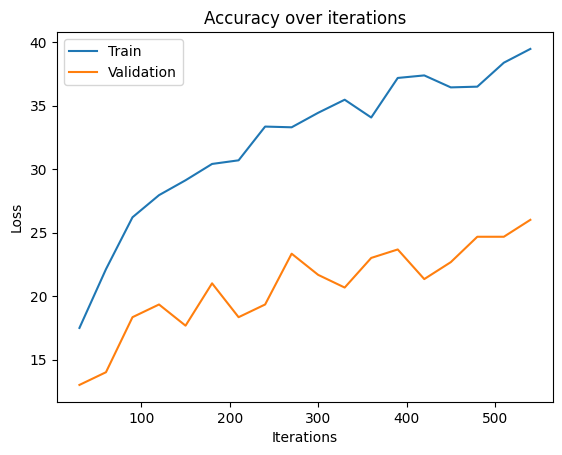

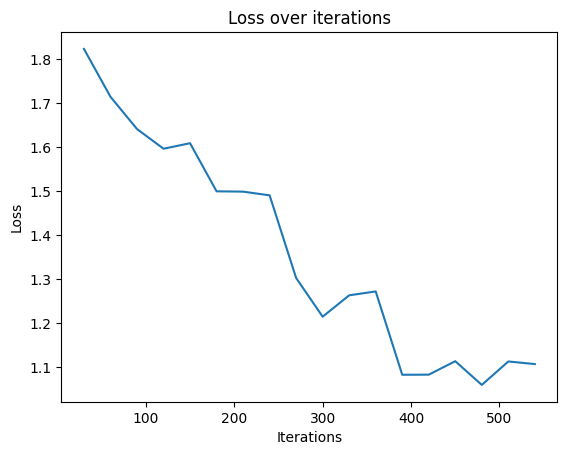

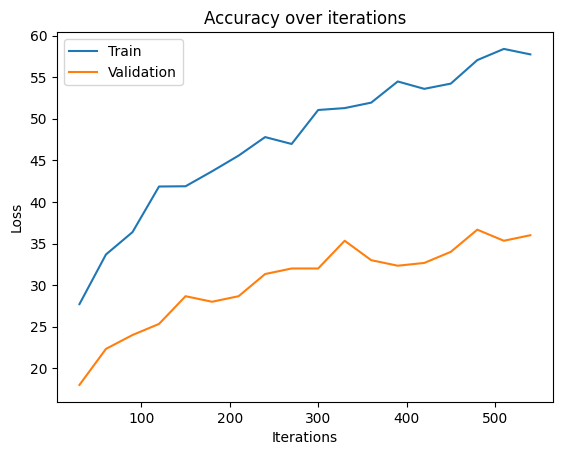

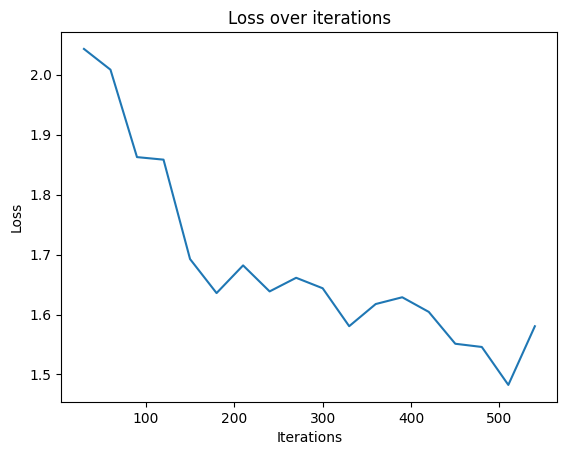

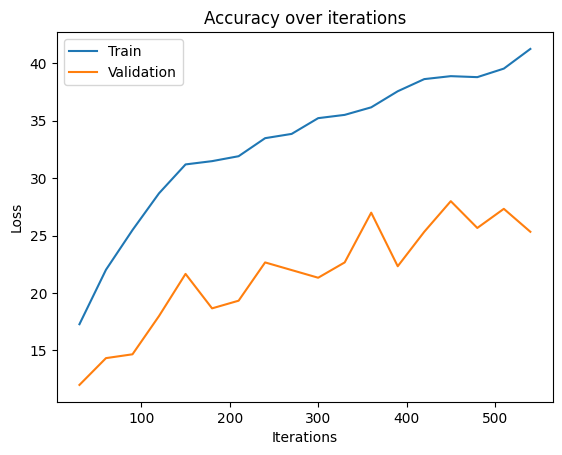

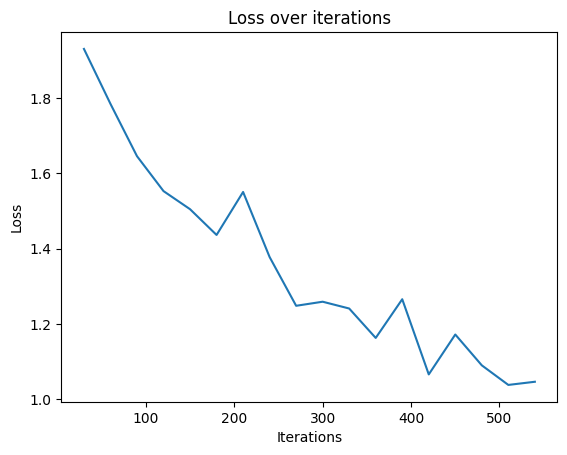

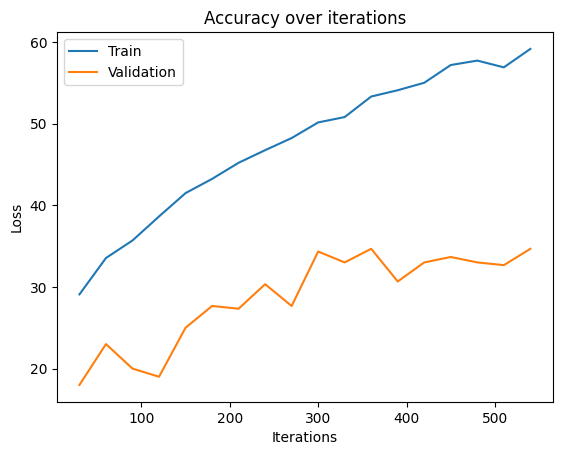

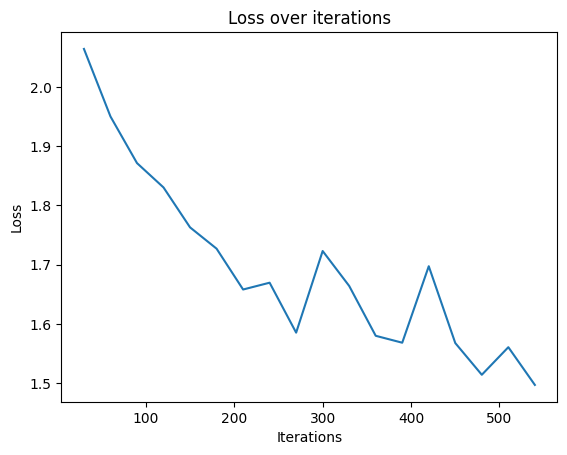

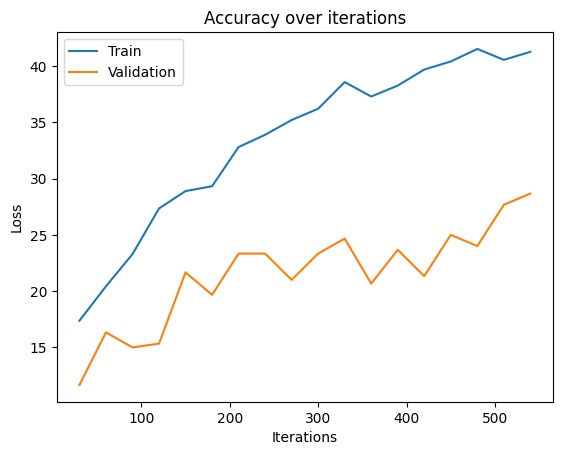

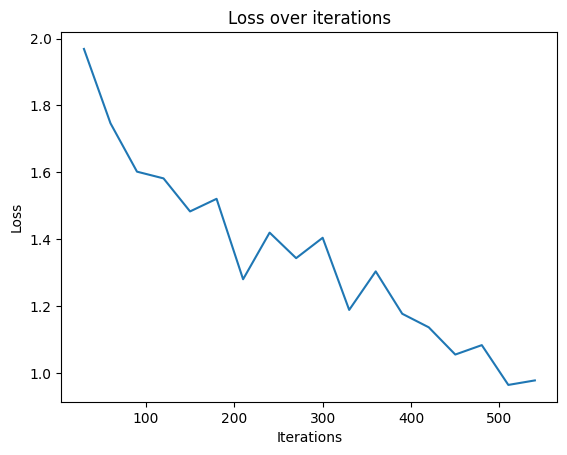

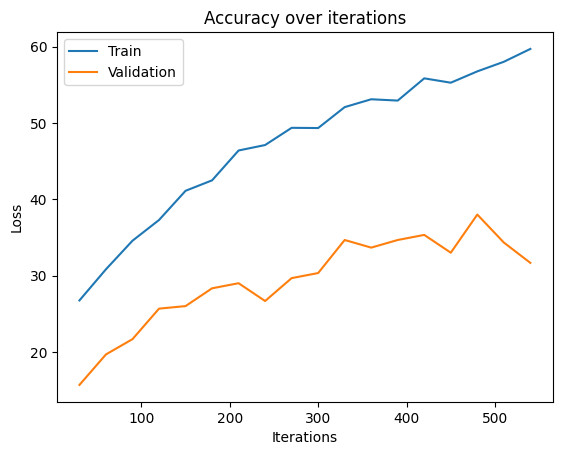

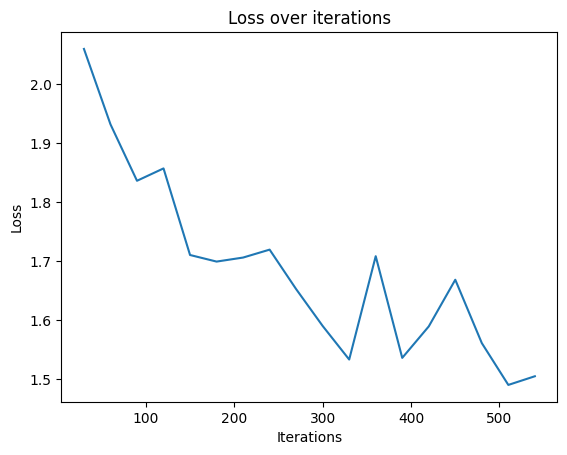

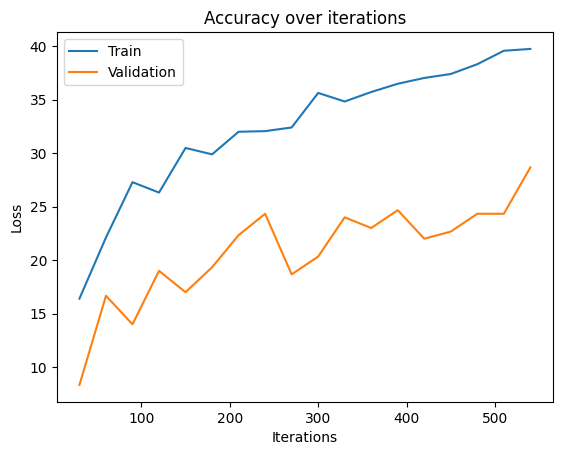

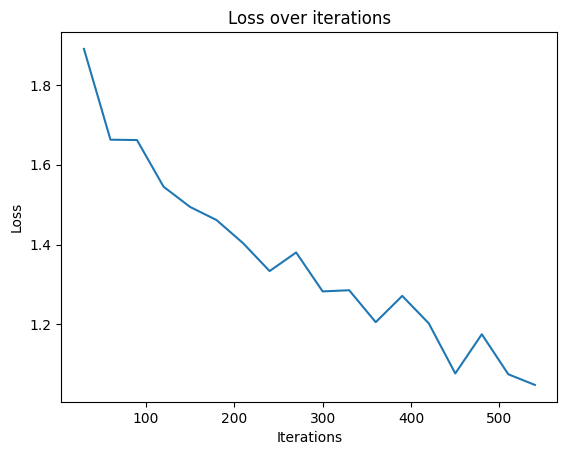

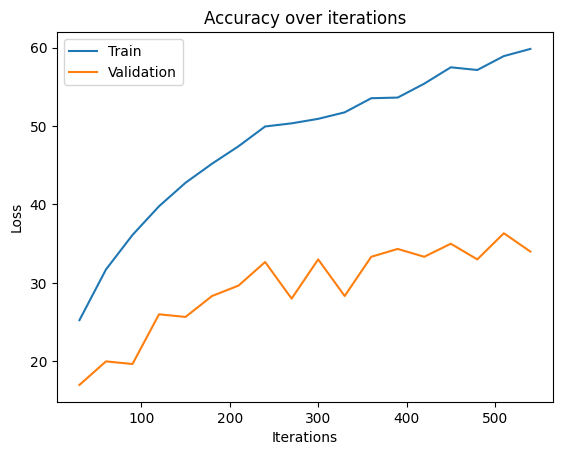

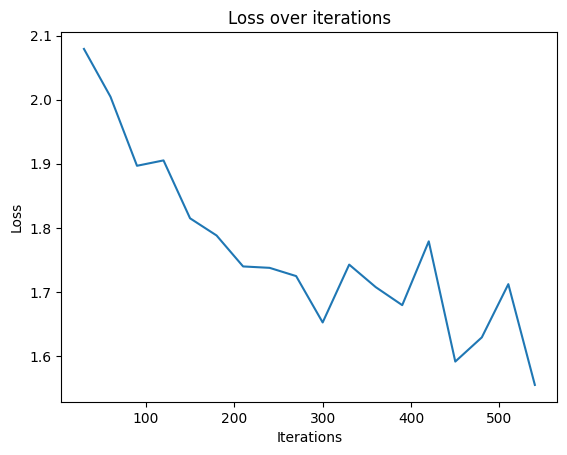

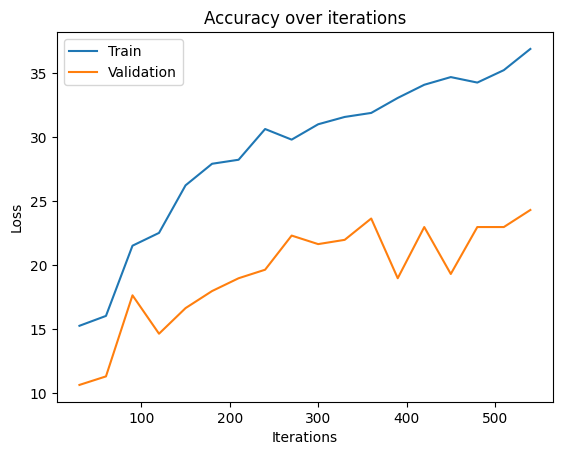

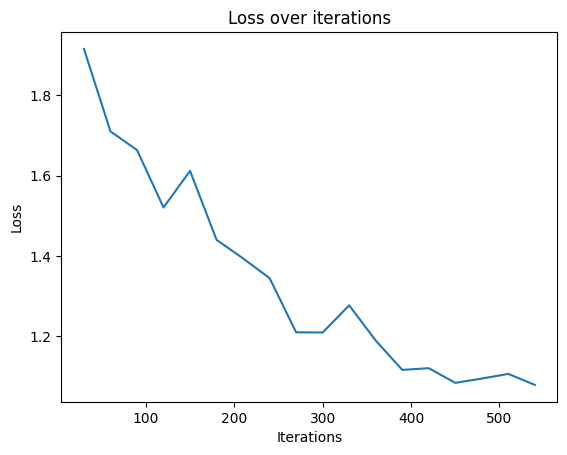

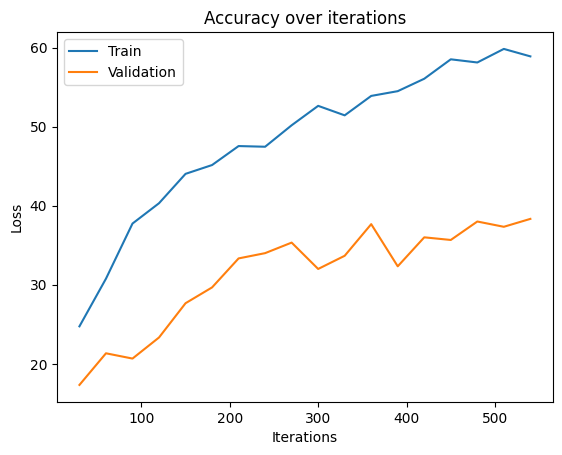

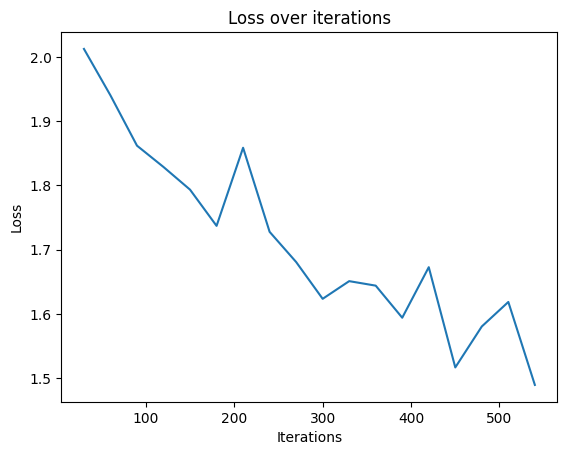

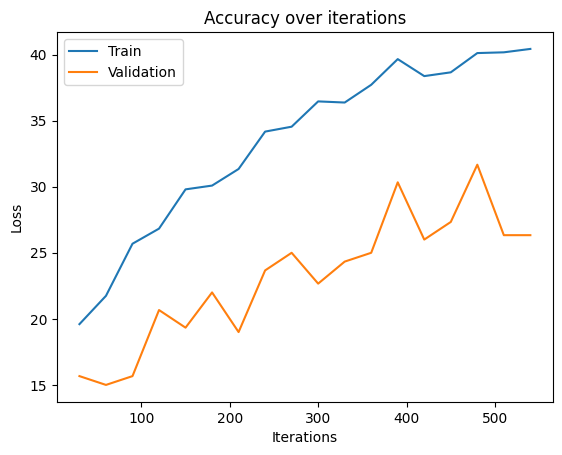

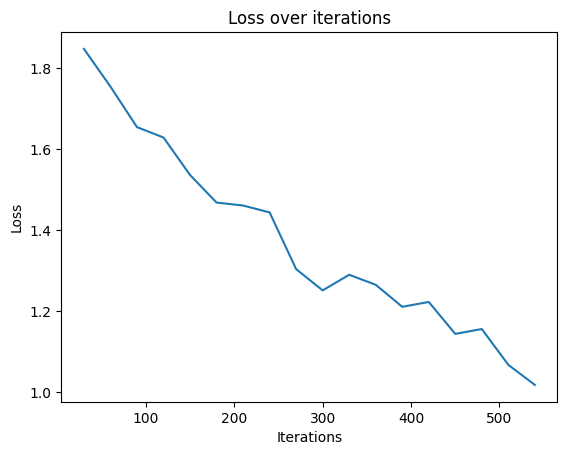

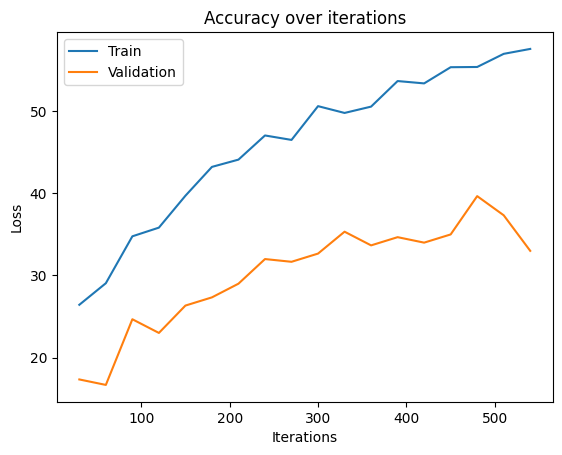

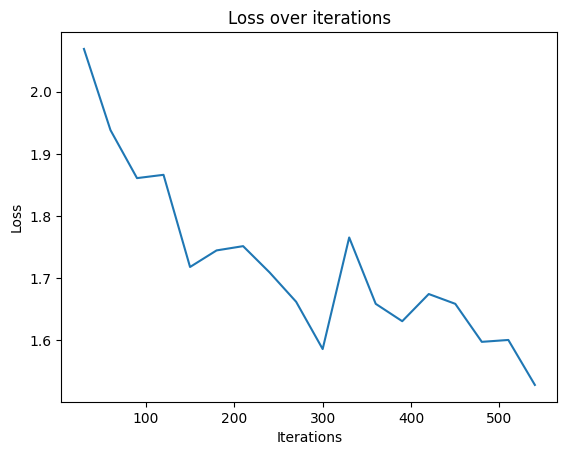

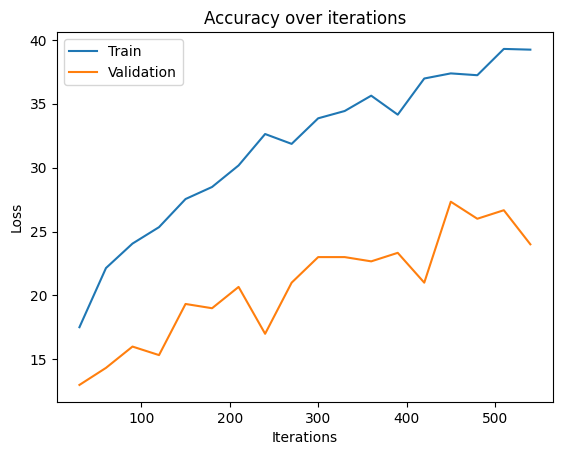

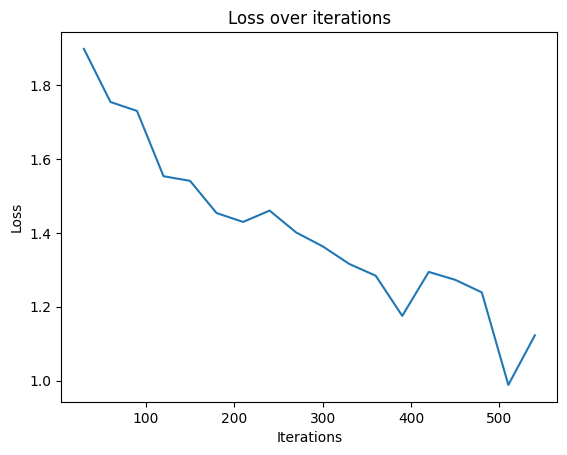

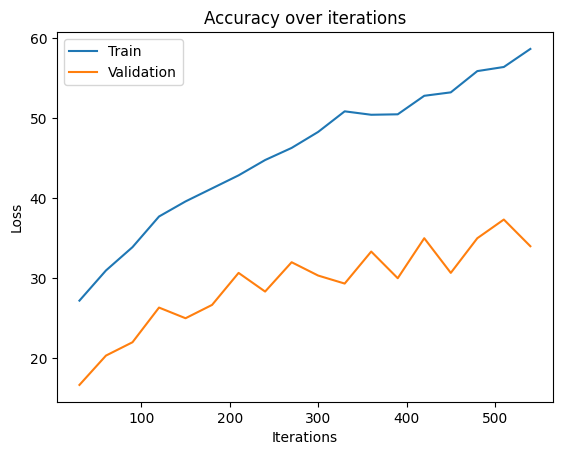

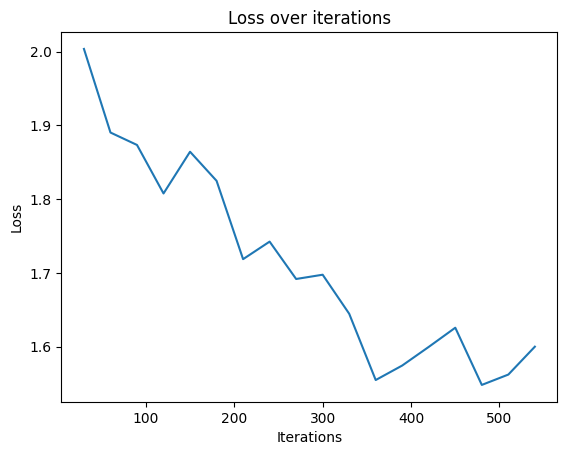

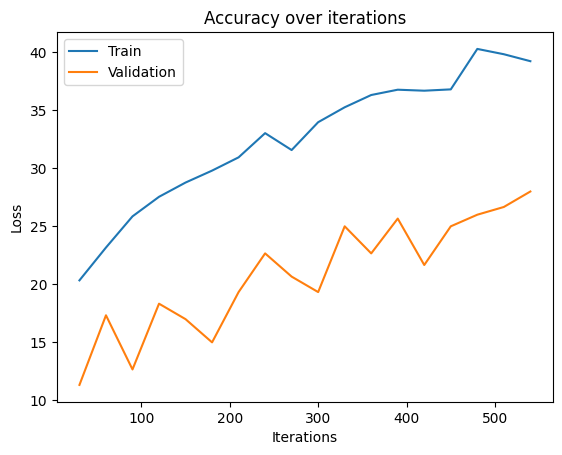

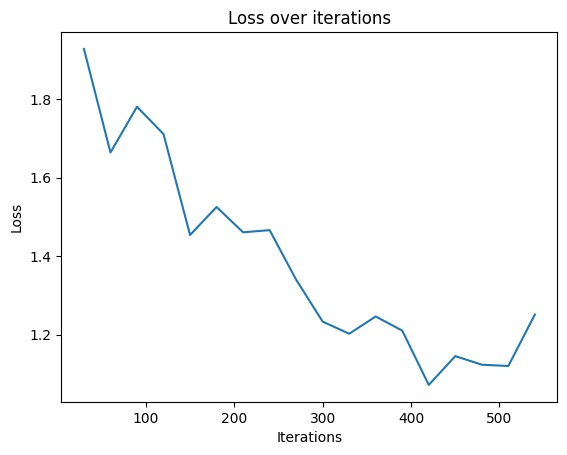

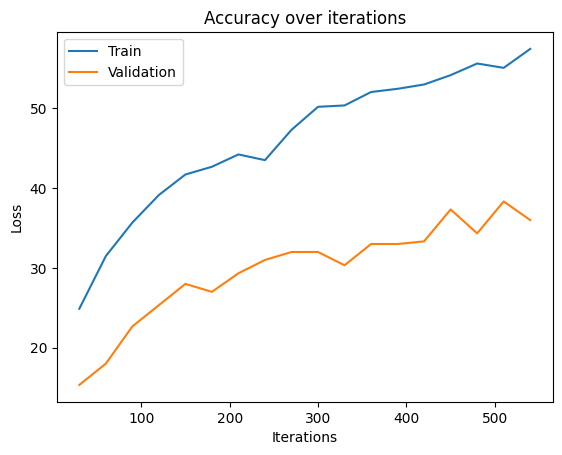

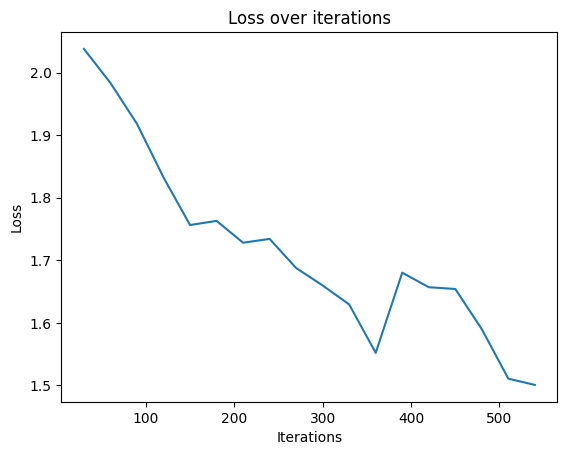

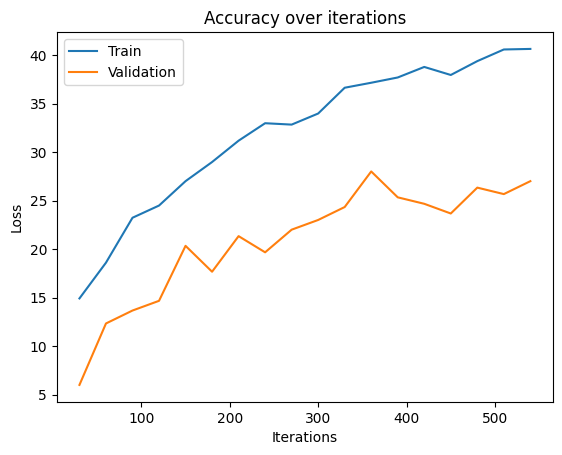

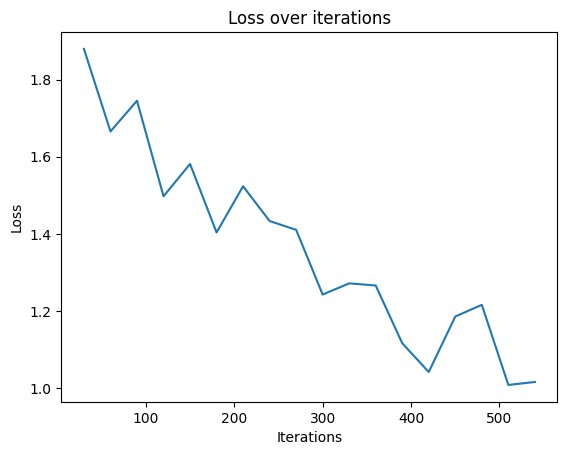

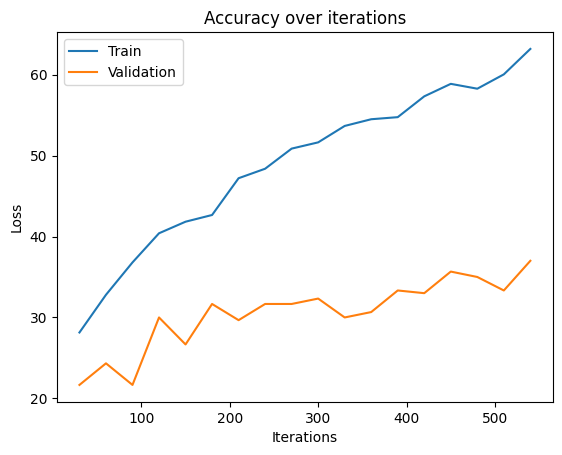

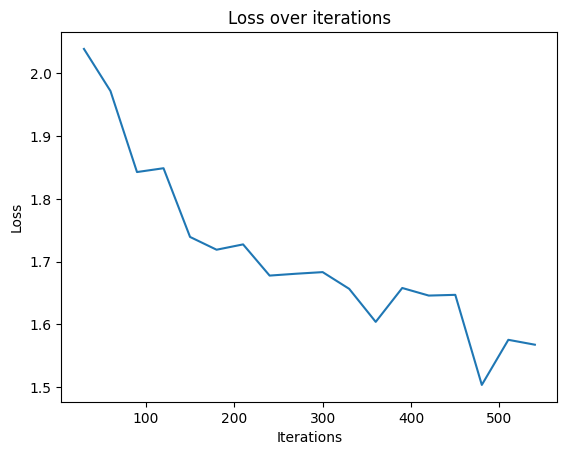

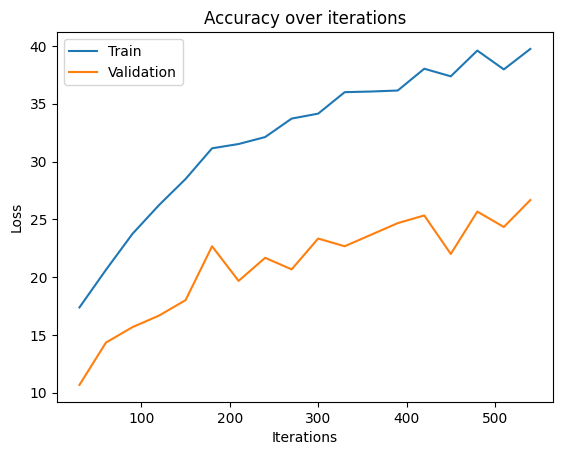

In [132]:
best_model = None
best_params = []
val_accuracy = 0

for ks1 in kernel_sizes1:
    for ks2 in kernel_sizes2:
        for pool_size in pool_sizes:
            for p in ps:
                model = SER_Dropout_Model(kernel_size1=ks1, kernel_size2=ks2, pool_size=pool_size, p=p)
                train_model(model, train_data2, val_data2, plot_every=30, batch_size=256, num_epochs=40)
                if accuracy(model, val_data2) > val_accuracy:
                    best_model = model
                    best_params = [ks1, ks2, pool_size, p]
                    val_accuracy = accuracy(model, val_data2)
                print("")
                    
print(best_model)

In [133]:
print(best_params)

[5, 3, 5, 0.25]


Epoch: 2 iteration: 30 Loss: 0.3029557764530182 Train Acc: 87.17142857142858 Val Acc: 39.0
Epoch: 4 iteration: 60 Loss: 0.31184980273246765 Train Acc: 87.74285714285715 Val Acc: 43.0
Epoch: 6 iteration: 90 Loss: 0.2581087350845337 Train Acc: 87.42857142857143 Val Acc: 42.333333333333336
Epoch: 8 iteration: 120 Loss: 0.2768486738204956 Train Acc: 87.88571428571429 Val Acc: 42.666666666666664
Epoch: 10 iteration: 150 Loss: 0.2653175890445709 Train Acc: 88.42857142857143 Val Acc: 42.0
Epoch: 12 iteration: 180 Loss: 0.2514713704586029 Train Acc: 89.37142857142857 Val Acc: 44.666666666666664
Epoch: 14 iteration: 210 Loss: 0.26182326674461365 Train Acc: 88.85714285714286 Val Acc: 41.0
Epoch: 17 iteration: 240 Loss: 0.26646631956100464 Train Acc: 89.02857142857142 Val Acc: 45.333333333333336
Epoch: 19 iteration: 270 Loss: 0.261349618434906 Train Acc: 88.88571428571429 Val Acc: 41.0
Epoch: 21 iteration: 300 Loss: 0.3364819884300232 Train Acc: 89.54285714285714 Val Acc: 43.333333333333336
Epoch

KeyboardInterrupt: 

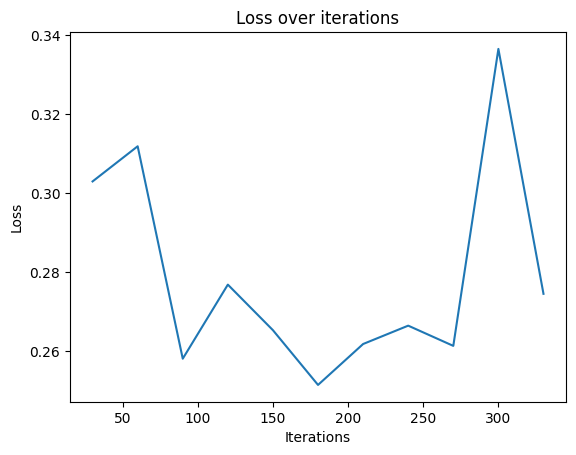

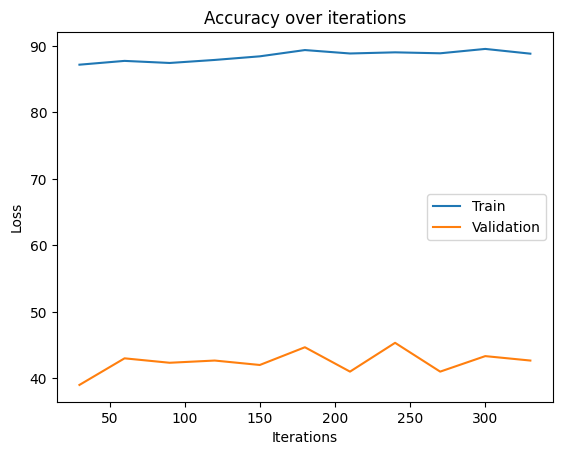

In [153]:
train_model(best_model, train_data2, val_data2, plot_every=30, batch_size=256, learning_rate=0.0001, num_epochs=80)

In [158]:
accuracy(best_model, test_data2)

51.25

In [151]:
torch.save(best_model.state_dict(), '/home/pankrat/project/model.pt')

In [138]:
class SER_NoDropout_Model(nn.Module):
    def __init__(self, input_size=input_size, pool_size=5, kernel_size1=3, kernel_size2=5, hidden_size=80, hidden_size2=10, cout=60, cout2=40, num_classes=8):
        # self.fcnn_size = fcnn_size
        # self.scnn_size = scnn_size

        # CNN to grab deep features from the spectrogram image
        super().__init__()

        pool_stride = 1
        pool_padding = 0
        stride = 2
        padding = 0

        self.MFCC_feature_extraction = nn.Sequential(
          nn.Conv1d(input_size, cout, kernel_size=kernel_size1, stride=stride, padding=padding),
          nn.MaxPool1d(kernel_size=pool_size, stride=pool_stride, padding=pool_padding),
          nn.Dropout(p),
          nn.Conv1d(cout, cout2, kernel_size=kernel_size2, stride=stride, padding=padding),
          nn.MaxPool1d(kernel_size=pool_size, stride=pool_stride, padding=pool_padding),
        )

        input_size3 = 4 * hidden_size

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(cout2, hidden_size, bidirectional=True, batch_first=True)

        self.classify = nn.Sequential(
          nn.BatchNorm1d(input_size3),
          nn.Linear(input_size3, hidden_size2),
          nn.ReLU(),
          nn.Linear(hidden_size2, 50),
          nn.ReLU(),
          nn.Linear(50, num_classes),
        )

    def forward(self, X):
        # Get deep features
        deep_features = self.MFCC_feature_extraction(X).squeeze(dim=1) # Get deep features
        out, (h_n, c_n) = self.lstm(deep_features.permute(0, 2, 1)) # Use h_n for deep features

        features = torch.cat([torch.amax(out, dim=1),
                              torch.mean(out, dim=1)], axis=-1)
        out = self.classify(features)
        return out

In [140]:
model_no_dropout = SER_NoDropout_Model(kernel_size1=5, kernel_size2=3, pool_size=5)

Epoch: 2 iteration: 30 Loss: 1.8165879249572754 Train Acc: 27.34285714285714 Val Acc: 18.333333333333332
Epoch: 4 iteration: 60 Loss: 1.5930020809173584 Train Acc: 38.25714285714286 Val Acc: 24.333333333333332
Epoch: 6 iteration: 90 Loss: 1.4995490312576294 Train Acc: 42.885714285714286 Val Acc: 26.0
Epoch: 8 iteration: 120 Loss: 1.4482691287994385 Train Acc: 44.714285714285715 Val Acc: 28.666666666666668
Epoch: 10 iteration: 150 Loss: 1.326725959777832 Train Acc: 48.457142857142856 Val Acc: 32.0
Epoch: 12 iteration: 180 Loss: 1.333329677581787 Train Acc: 52.08571428571429 Val Acc: 36.333333333333336
Epoch: 14 iteration: 210 Loss: 1.2479552030563354 Train Acc: 54.68571428571428 Val Acc: 33.666666666666664
Epoch: 17 iteration: 240 Loss: 1.1351685523986816 Train Acc: 55.94285714285714 Val Acc: 36.666666666666664
Epoch: 19 iteration: 270 Loss: 1.2468256950378418 Train Acc: 57.34285714285714 Val Acc: 36.0
Epoch: 21 iteration: 300 Loss: 1.0597870349884033 Train Acc: 59.857142857142854 Val A

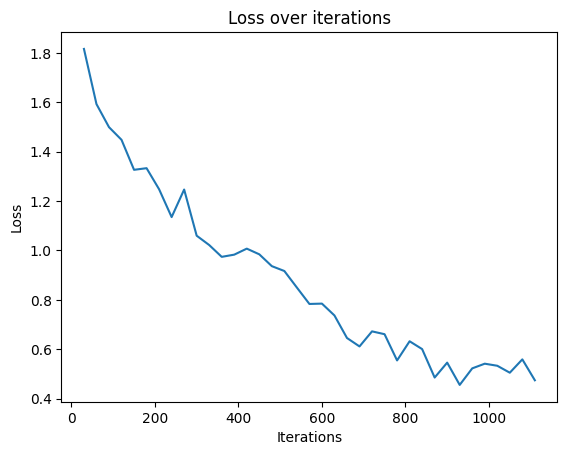

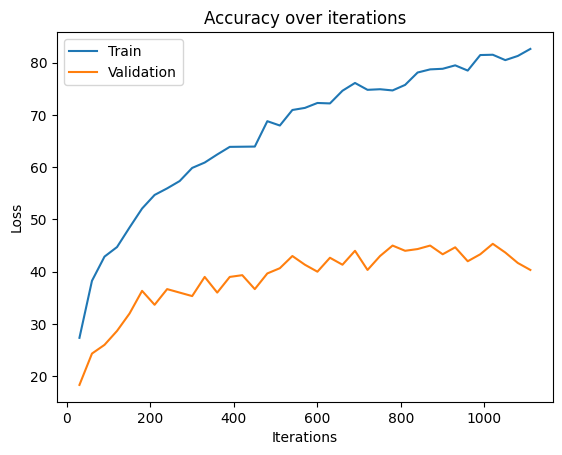

In [142]:
train_model(model_no_dropout, train_data2, val_data2, plot_every=30, batch_size=256, num_epochs=80)

In [157]:
accuracy(model_no_dropout, test_data2)

51.5